### Create geometry

In [1]:
import time
start_time = time.time()

In [29]:

# To run on jupyter
patient_number       = "demo"
N                    = 250 # 3 #
obtain_training_data = "compute_points" #
nIter                = 300 # 2 #
criterion_bo         = "EI" # "LCB" # "LW-LCB"
optimization_points  =   "run_opt" # "load_opt_points"

In [3]:
print ( "#####################################")
print (f"Running analysis of patient {patient_number}")
print (f"N = {N}, {obtain_training_data}            ") 
print (f"nIter = {nIter}, {optimization_points}  ")
print ( "#####################################")

#####################################
Running analysis of patient demo
N = 250, compute_points            
nIter = 300, load_opt_points  
#####################################


In [4]:


from bo_purkinje_demo import BO_Purkinje
from PurkinjeECG.Myocardium_demo import MyocardialMesh

Import of Cupy failed. The GPU version of fimpy will be unavailable. Message: No module named 'cupy'


In [5]:

from bo_ecg import BO_ecg

/Users/fsc/anaconda3/envs/purkinje-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import numpy as onp
import jax.numpy as np
import jax
jax.config.update("jax_enable_x64", True)

from jax import random, lax
from jaxbo.models import GP
from jaxbo.utils import normalize

import matplotlib.pyplot as plt
import os
import shutil
import pickle
import pandas as pd
import seaborn as sns

from jax import ops
from scipy.stats import norm

onp.random.seed(1234)

### Create reference tree

In [7]:
if patient_number == "demo":
    patient = "PurkinjeECG/data/crtdemo/crtdemo"
#     qrs_in, qrs_fin = 200, 400
    meshes_list_pat = [388, 412, 198, 186] # These are node indices (of the LV and RV endocardial meshes) that determine the direction of the
                                           # initial branch of the Purkinje Tree
                                           # Here, 388 and 412 are nodes of the LV endocardial mesh and
                                           #       198 and 186 are nodes of the RV endocardial mesh
    myo = MyocardialMesh(myo_mesh            = f"{patient}_mesh_oriented.vtk",
                    electrodes_position = f"PurkinjeECG/data/crtdemo/electrode_pos.pkl",
                    fibers              = f"{patient}_f0_oriented.vtk",
                    device = 'cpu') # or 'gpu' is available

else:
    raise Exception("patient_number must be 'demo'")

Conduction velocity in the direction of the fibers: 0.8660254037844386 m/s
assembling Laplacian
initializing FIM solver
0.05359697341918945


In [8]:
# Demo
true_parameters_values = {"patient"         : patient,
                          "meshes_list"     : meshes_list_pat, 
                          "init_length"     : 0., 
                          "length"          : 8.,
                          "w"               : 0.1, 
                          "l_segment"       : 1.,
                          "fascicles_length": 0., 
                          "fascicles_angles": 0., 
                          "branch_angle"    : 0.15,
                          "N_it"            : 20,
                          "myocardium"      : myo}

Tree_true      = BO_Purkinje(**true_parameters_values)
bo_method_true = BO_ecg(bo_purkinje_tree = Tree_true)

if not os.path.exists("./output/patient"+str(patient_number)):
    os.makedirs("./output/patient"+str(patient_number))

computing uv map
computing uv map


In [9]:

print ("Reading results of patient 1 ...")
if patient_number == "demo":
    X_read = onp.load("PurkinjeECG/output/patient1/data_X_N_250_nIter_300_criterionEI_init_length_fascicles_length_fascicles_angles_root_time_cv.npy")

    y_read = onp.load("PurkinjeECG/output/patient1/data_y_N_250_nIter_300_criterionEI_init_length_fascicles_length_fascicles_angles_root_time_cv.npy")
    
    X_min = X_read[onp.argmin(y_read)]
    y_min = onp.min(y_read)
    

var_params_true = {"init_length"     : [X_min[0], X_min[1]],
                   "fascicles_length": [[0.5*X_min[2], 0.5*X_min[3]],
                                        [0.5*X_min[4], 0.5*X_min[5]]],
                   "fascicles_angles": [[0.1*X_min[6], 0.1*X_min[7]],
                                        [0.1*X_min[8], 0.1*X_min[9]]],
                   "root_time"       : X_min[10],
                   "cv"              : X_min[11]}



print ("Ground truth")
print (f"X_ground_truth: {var_params_true}")

Reading results of patient 1 ...
Ground truth
X_ground_truth: {'init_length': [np.float64(35.931537038275316), np.float64(79.86354832236707)], 'fascicles_length': [[np.float64(4.711579058738858), np.float64(9.129484609771032)], [np.float64(21.703867933650002), np.float64(5.79561866201451)]], 'fascicles_angles': [[np.float64(0.14448952070696136), np.float64(0.23561944901923448)], [np.float64(0.23561944901923448), np.float64(0.23561944901923448)]], 'root_time': np.float64(-75.0), 'cv': np.float64(2.0)}


In [10]:
ecg_true, LVtree_true, RVtree_true = bo_method_true.bo_purkinje_tree.run_ECG(n_sim=0, modify=True, side='both', **var_params_true)

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.01048898696899414
solving
1.6850688457489014
Iteration 0, nLV = 20, nRV = 62
computing closest nodes to PMJs
0.007794857025146484
solving
1.6631360054016113
Iteration 1, nLV = 23, nRV = 30
ECG error = 0.15901152912720182
computing closest nodes to PMJs
0.007812976837158203
solving
1.6364409923553467
Iteration 2, nLV = 9, nRV = 17
ECG error = 0.0029786623041704896


In [11]:
# Save true trees and endo
file_name = f"./output/patient{patient_number}/"

pickle.dump(ecg_true, open(f"./output/patient{patient_number}/True_ecg","wb"))
myo.save_pv(file_name+"True_endo.vtu")
LVtree_true.save(file_name+"True_LVtree.vtu")
RVtree_true.save(file_name+"True_RVtree.vtu")

In [12]:
qrs_in, qrs_fin = 0, len (ecg_true) # in this case we will use the full ecgs
ecg_pat_array = ecg_true[qrs_in:qrs_fin]

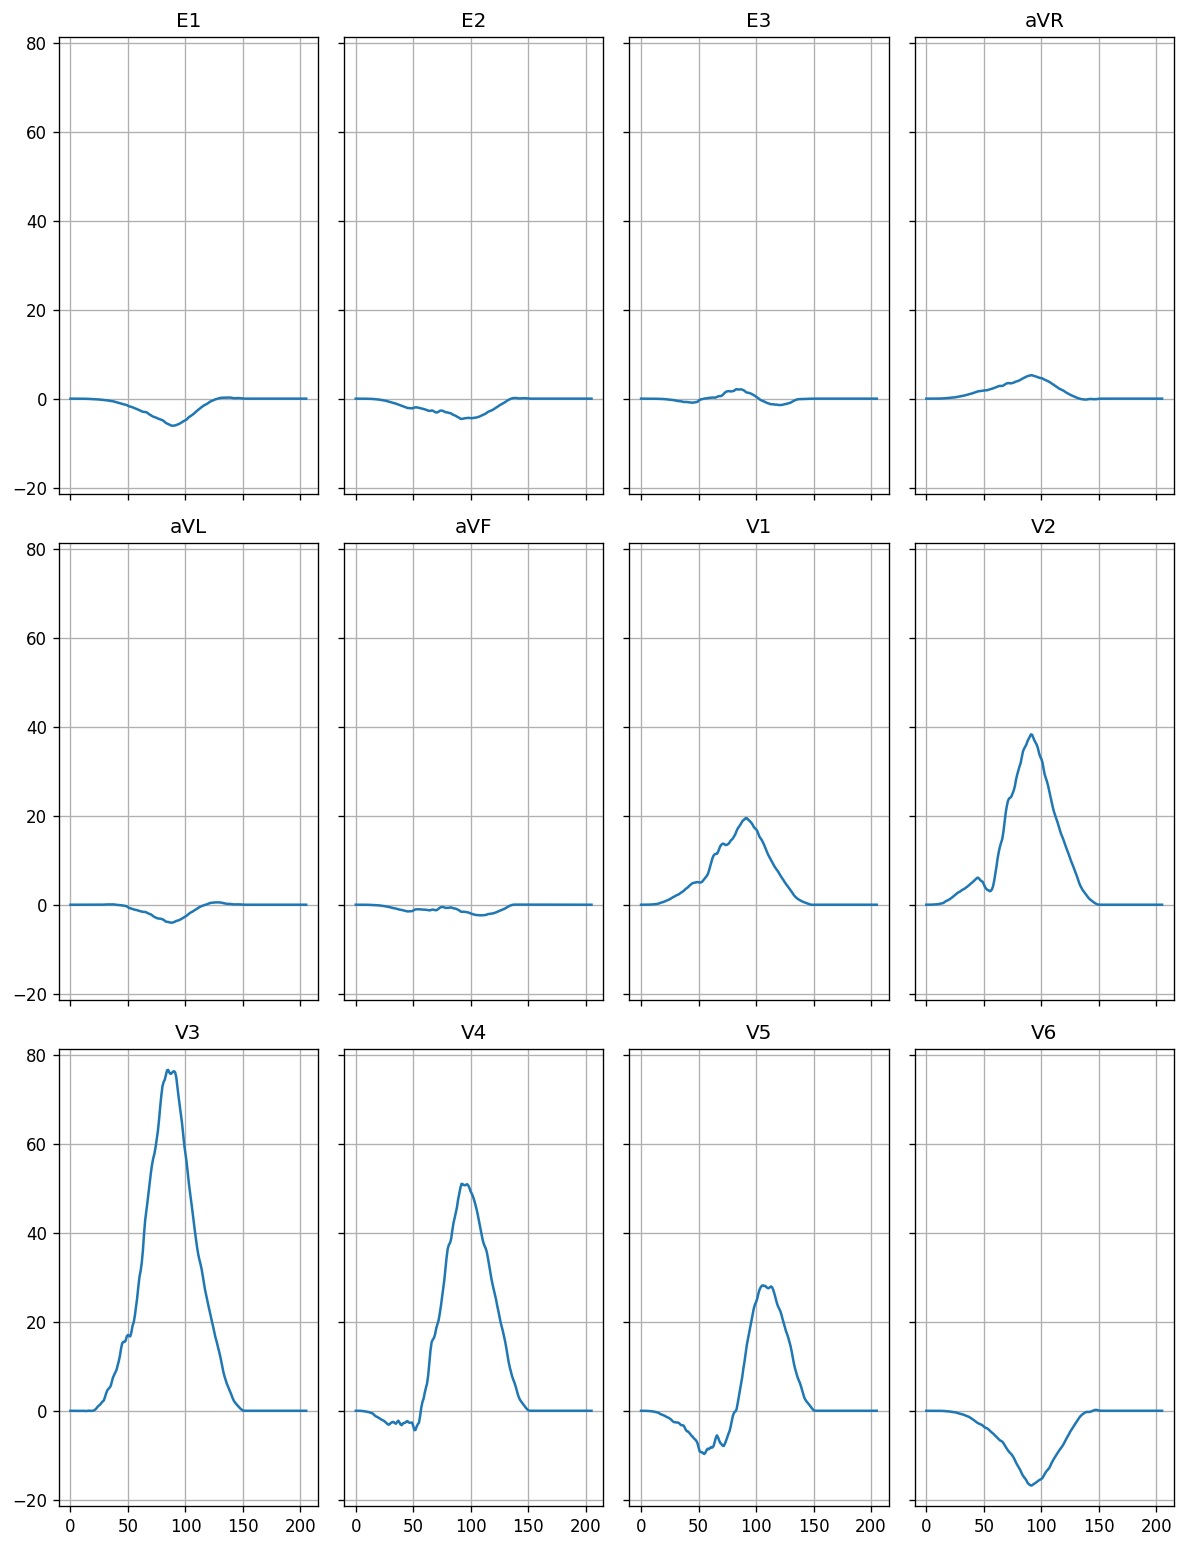

In [13]:
plot_reference_ecg = True

if plot_reference_ecg:
    fig,axs = plt.subplots(3, 4, figsize=(10,13), dpi=120, sharex=True, sharey=True)
    for ax,l in zip(axs.ravel(),ecg_pat_array.dtype.names):
        ax.plot(ecg_pat_array[l])
        ax.grid()
        ax.set_title(l)
    #     ax.legend()
    fig.tight_layout()
    plt.show()

In [14]:
# NOTE: In bo_ecg.calculate_loss(), cut_fin = 0, as here we compare the full ecgs.

### Bayesian optimization (with jaxbo)

In [15]:
dim = 2

def var_parameters_dict(var_parameters_names):
    # Parameters to find
    var_parameters = {}
    
    # init_length
    if "init_length" in var_parameters_names:
        lb_init_length                = 30.0 * onp.ones(dim)
        ub_init_length                = 100.0 * onp.ones(dim)
        var_parameters["init_length"] = [lb_init_length, ub_init_length, "uniform"]

    # length
    if "length" in var_parameters_names:
        lb_length                = 4. * onp.ones(1)
        ub_length                = 12. * onp.ones(1)
        var_parameters["length"] = [lb_length, ub_length, "uniform"]

    # w
    if "w" in var_parameters_names:
        lb_w                = 0.05* onp.ones(1) # 0.05
        ub_w                = 0.25 * onp.ones(1) # 0.8
        var_parameters["w"] = [lb_w, ub_w, "uniform"]

    # l_segment
    if "l_segment" in var_parameters_names:
        lb_l_segment                = 1. * onp.ones(dim)
        ub_l_segment                = 15. * onp.ones(dim)
        var_parameters["l_segment"] = [lb_l_segment, ub_l_segment, "uniform"]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        lb_fascicles_length                = 2.0 * onp.ones(2*dim) # 10 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_length                = 50.0 * onp.ones(2*dim) # 30
        var_parameters["fascicles_length"] = [lb_fascicles_length, ub_fascicles_length, "uniform"]

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        lb_fascicles_angles                = -1./4. * onp.pi * np.ones(2*dim) # 0.1 # 2.*dim because there are 2 params per ventricle 
        ub_fascicles_angles                =  3./4. * onp.pi * np.ones(2*dim) # 1.57
        var_parameters["fascicles_angles"] = [lb_fascicles_angles, ub_fascicles_angles, "uniform"]

    # branch_angle
    if "branch_angle" in var_parameters_names:
        lb_branch_angle                = 5. * onp.pi/180. * np.ones(1)
        ub_branch_angle                = 45. * onp.pi/180. * np.ones(1)
        var_parameters["branch_angle"] = [lb_branch_angle, ub_branch_angle, "uniform"]
    
    # root_time
    if "root_time" in var_parameters_names:
        lb_root_time                = -75. * np.ones(1)
        ub_root_time                = 50. * np.ones(1)
        var_parameters["root_time"] = [lb_root_time, ub_root_time, "uniform"]
        
    # cv
    if "cv" in var_parameters_names:
        lb_cv                = 2. * np.ones(1)
        ub_cv                = 4. * np.ones(1)
        var_parameters["cv"] = [lb_cv, ub_cv, "uniform"]
        
    return var_parameters


def initial_values(var_parameters_names, patient, meshes_list_pat, myocardium):
    # Initial values for known parameters    
    meshes_list  = meshes_list_pat
    init_length  = 30
    length       = 8. # [mm]
    w            = 0.1
    l_segment    = 1.0

    f_len        = [20.0, 20.0] 
    f_angles     = [1., 1.] 

    branch_angle = 0.15 #20. * onp.pi/180. #0.15
    N_it         = 20

    # Assign 1. to the parameters to find
    # init_length
    if "init_length" in var_parameters_names:
        init_length_bo = 1.
    else:
        init_length_bo = init_length 

    # length
    if "length" in var_parameters_names:
        length_bo = 1.
    else:
        length_bo = length # [mm]

    # w
    if "w" in var_parameters_names:
        w_bo = 1.
    else:
        w_bo = w
        
    # l_segment
    if "l_segment" in var_parameters_names:
        l_segment_bo = 1.
    else:
        l_segment_bo = l_segment # [mm]

    # fascicles_length
    if "fascicles_length" in var_parameters_names:
        f_len_bo = [1., 1.]
    else:
        f_len_bo = f_len

    # f_angles
    if "fascicles_angles" in var_parameters_names:
        f_angles_bo = [1., 1.] 
    else:
        f_angles_bo = f_angles

    # branch_angle
    if "branch_angle" in var_parameters_names:
        branch_angle_bo = 1.
    else:
        branch_angle_bo = branch_angle

    parameters_values = {"patient"         : patient,
                         "meshes_list"     : meshes_list, 
                         "init_length"     : init_length_bo, 
                         "length"          : length_bo, 
                         "w"               : w_bo, 
                         "l_segment"       : l_segment_bo, 
                         "fascicles_length": f_len_bo, 
                         "fascicles_angles": f_angles_bo, 
                         "branch_angle"    : branch_angle_bo, 
                         "N_it"            : N_it,
                         "myocardium"      : myocardium}
    
    return parameters_values

In [16]:
var_parameters_list = ["init_length", "fascicles_length", "fascicles_angles","root_time", "cv"]
# var_parameters_list = ["init_length", "length", "w", "fascicles_length", "fascicles_angles",
#                        "branch_angle", "root_time", "cv"]

#assert var_parameters_list == var_parameters_read, "Variables do not match ground truth variables"

initial_params = initial_values(var_parameters_list, patient, meshes_list_pat, myo)
Tree_bo        = BO_Purkinje(**initial_params)
bo_method      = BO_ecg(bo_purkinje_tree = Tree_bo)

# f is the mse between real (ecg_pat_array) and computed ecg
var_parameters = var_parameters_dict(var_parameters_list)
f, p_x         = bo_method.mse_jaxbo(ground_truth = ecg_pat_array, variable_parameters = var_parameters)

computing uv map
computing uv map


In [17]:
x = np.array([74.12523435, 62.46094801, 24.19023292, 40.65849346, 32.69169548, 49.33628498,
  1.08097521, -0.73921825,  0.74647183,  1.68333156, 12.50440764,  2.5114008 ])
bo_method.set_dictionary_variables(bo_method.variable_parameters, list(onp.array(x)))

{'init_length': [74.12523435, 62.46094801],
 'fascicles_length': [[24.19023292, 40.65849346], [32.69169548, 49.33628498]],
 'fascicles_angles': [[1.08097521, -0.73921825], [0.74647183, 1.68333156]],
 'root_time': 12.50440764,
 'cv': 2.5114008}

In [18]:
[float(a) for a in x]

[74.12523435,
 62.46094801,
 24.19023292,
 40.65849346,
 32.69169548,
 49.33628498,
 1.08097521,
 -0.73921825,
 0.74647183,
 1.68333156,
 12.50440764,
 2.5114008]

In [19]:
if obtain_training_data == "compute_points":
    print ("Computing training points ...")
    t_ini_train = time.time()    

    bo_method.y_trees_non_valid = 10.
    noise                       = 0.0
    X, y                        = bo_method.set_initial_training_data(N, noise)

    onp.save("./output/patient"+str(patient_number)+"/data_X_"+str(N)+"_"+
                "_".join(list(var_parameters.keys())), X)
    onp.save("./output/patient"+str(patient_number)+"/data_y_"+str(N)+"_"+
                "_".join(list(var_parameters.keys())), y)
    onp.save("./output/patient"+str(patient_number)+"/data_noise_"+str(N)+"_"+
                "_".join(list(var_parameters.keys())), noise)
    
    t_fin_train = time.time()
    print(f"Train time: {t_fin_train - t_ini_train} s")

elif obtain_training_data == "load_data":
    print ("Loading training points ...")

    X     = np.load("./output/patient"+str(patient_number)+"/data_X_"+str(N)+"_"+
                "_".join(list(var_parameters.keys()))+".npy") 
    y     = np.load("./output/patient"+str(patient_number)+"/data_y_"+str(N)+"_"+
                "_".join(list(var_parameters.keys()))+".npy")
    noise = np.load("./output/patient"+str(patient_number)+"/data_noise_"+str(N)+"_"+
                "_".join(list(var_parameters.keys()))+".npy")
        
    bo_method.noise = noise

Computing training points ...
[74.12523435 62.46094801 24.19023292 40.65849346 32.69169548 49.33628498
  1.08097521 -0.73921825  0.74647183  1.68333156 12.50440764  2.5114008 ]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[68.09573814 54.84893483 46.74587201 17.61712977 18.19601436 16.3576575
  2.09864116  2.31702313 -0.45879563  2.06693138  4.21911364  2.85566539]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006322145462036133
solving
0.9275100231170654
Iteration 0, nLV = 2, nRV = 40
computing closest nodes to PMJs
0.006396055221557617
solving
0.9300508499145508
Iteration 1, nLV = 1, nRV = 17
ECG error = 0.00046978559732784627
Loss: 1357.138211897616
[46.61995663 80.25291714  6.14057921 47.21590863 39.06941815 15.77165648
  2.13687669  1.55979661 -0.17547947 -0.61174721 28.79528727  3.83669789]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005981922149658203
solving
0.9874496459960938
Iteration 0, nLV = 0, nRV = 31
computing closest nodes to PMJs
0.005655050277709961
solving
0.9886040687561035
Iteration 1, nLV = 0, nRV = 16
ECG error = 0.0
Loss: 2711.3406426022984
[ 4.97059673e+01  5.98388536e+01  1.15534348e+01  3.62390882e+01
  2.88514733e+01  1.52696700e+01  1.21097496e+00 -7.06221965e-01
  9.71268306e-01 -5.10269556e-02 -5.34662304e+01  2.75272716e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generati

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.004909038543701172
solving
1.610299825668335
Iteration 0, nLV = 0, nRV = 87
computing closest nodes to PMJs
0.0046558380126953125
solving
1.5884201526641846
Iteration 1, nLV = 0, nRV = 28
ECG error = 0.04934596745749708
computing closest nodes to PMJs
0.0046367645263671875
solving
1.5601990222930908
Iteration 2, nLV = 0, nRV = 22
ECG error = 0.0020070860483037095
Loss: 5335.586409593387
[ 60.28763424  37.32413446  31.68192035  39.46338742  49.19815459
  16.83846064   2.33803049   0.5438803    0.17735487  -0.4088143
 -74.82109137   3.66342936]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
gene

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006671905517578125
solving
1.0519132614135742
Iteration 0, nLV = 7, nRV = 36
computing closest nodes to PMJs
0.006371259689331055
solving
1.05100679397583
Iteration 1, nLV = 3, nRV = 14
ECG error = 0.0007909627888519709
Loss: 1955.1371656211406
[ 92.68125887  45.64647155  36.55502851   3.66452897  27.52294185
  37.6957921    1.74394523  -0.56220875   0.62331859  -0.32766549
 -10.99254873   2.90326054]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 51.96499393  53.20172819  20.97430601  31.03671872  35.51276516
   3.25488352  -0.3133163   -0.3671163    0.33686276   0.58573063
 -54.96697955   2.11761084]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
ge

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005899190902709961
solving
1.599426031112671
Iteration 0, nLV = 2, nRV = 68
computing closest nodes to PMJs
0.005877017974853516
solving
1.5778257846832275
Iteration 1, nLV = 1, nRV = 33
ECG error = 0.11374565565235505
computing closest nodes to PMJs
0.005850315093994141
solving
1.5638298988342285
Iteration 2, nLV = 1, nRV = 27
ECG error = 0.0022556599188951042
Loss: 483.0560160484204
[ 47.76430701  65.21720732  34.39818315   9.6550123   20.31241082
  10.99093694   1.4244197    2.14666036   1.79135873   1.75066888
 -25.26750861   2.12100964]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
gener

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0062558650970458984
solving
1.3493211269378662
Iteration 0, nLV = 23, nRV = 74
computing closest nodes to PMJs
0.006181955337524414
solving
1.2975070476531982
Iteration 1, nLV = 14, nRV = 26
ECG error = 0.07968986446294628
computing closest nodes to PMJs
0.006203889846801758
solving
1.289280891418457
Iteration 2, nLV = 14, nRV = 20
ECG error = 0.0
Loss: 2645.8808851380063
[ 35.38252938  51.4092921   13.61837303  19.46694556   9.35797228
  43.04151731   0.99058099   1.38118664   1.9770734    0.60048997
 -42.67037407   3.97194315]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generat

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Changing units ...
computing closest nodes to PMJs
0.002716064453125
solving
1.1215989589691162
Iteration 0, nLV = 0, nRV = 7
computing closest nodes to PMJs
0.0026679039001464844
solving
1.1044459342956543
Iteration 1, nLV = 0, nRV = 3
ECG error = 4.647160109285222e-08
Loss: 2782.2838643376135
[92.27031624 61.41532464 17.7891283  38.45647834  8.70191498 38.72521009
  1.37876381 -0.1310306   1.92245772  2.3330164  37.31925066  2.3044158 ]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[41.77116742 93.60337318  7.33437127 13.57049225  9.493255   14.49767204
  0.81119352 -0.75478431  1.32435168 -0.72106613 35.89650399  2.60478908]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0077898502349853516
solving
1.3621439933776855
Iteration 0, nLV = 6, nRV = 128
computing closest nodes to PMJs
0.007810115814208984
solving
1.3358371257781982
Iteration 1, nLV = 3, nRV = 53
ECG error = 0.05255815432897874
computing closest nodes to PMJs
0.00780177116394043
solving
1.340914249420166
Iteration 2, nLV = 3, nRV = 43
ECG error = 0.0
Loss: 5136.178524410323
[ 37.08004575  38.51562955   8.58533901  29.55149463  38.53083471
   6.79686893   0.14046719  -0.67785817  -0.30864279   0.15548006
 -62.68601747   3.48323652]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
ge

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.004340171813964844
solving
1.1031978130340576
Iteration 0, nLV = 0, nRV = 6
computing closest nodes to PMJs
0.004106044769287109
solving
1.1004877090454102
Iteration 1, nLV = 0, nRV = 2
ECG error = 0.0005912603078120941
Loss: 1426.7613584038343
[67.37235913 89.36483968 48.23176554 25.10897441 11.09592424 42.30292364
  1.58583208  1.9483501   0.76864982  1.04243391 40.82178461  2.98417834]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[71.49733713 68.15789367 47.31302477 26.66352875 37.26499982 28.22616648
  1.13677205  0.82536485 -0.69079571  1.34420426 -5.02610907  3.83163224]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 35.60061304  84.25731858  27.06969306  12.25474228  11.90892361
   7.14046183   1.53060461   1.408

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007632017135620117
solving
1.2393298149108887
Iteration 0, nLV = 14, nRV = 65
computing closest nodes to PMJs
0.007590055465698242
solving
1.2205889225006104
Iteration 1, nLV = 6, nRV = 35
ECG error = 0.02903538519950228
computing closest nodes to PMJs
0.007673025131225586
solving
1.2074968814849854
Iteration 2, nLV = 4, nRV = 34
ECG error = 3.888251361063843e-06
Loss: 1548.8290379212087
[ 85.12438024  92.28785727   9.50548931  49.83379235   8.47327883
  26.1011316    0.83268928   0.29616262  -0.29360641  -0.37753149
 -44.49922812   3.93653505]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[36.03771703 55.38314189 18.98318932 36.71569639 31.15105452 36.74445047
  0.46596546 -0.46494

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006139993667602539
solving
1.1728708744049072
Iteration 0, nLV = 2, nRV = 72
computing closest nodes to PMJs
0.006180763244628906
solving
1.1023979187011719
Iteration 1, nLV = 1, nRV = 45
ECG error = 0.1393564922616947
computing closest nodes to PMJs
0.006110191345214844
solving
1.1062021255493164
Iteration 2, nLV = 1, nRV = 30
ECG error = 0.02135196471858328
computing closest nodes to PMJs
0.006161928176879883
solving
1.0962228775024414
Iteration 3, nLV = 1, nRV = 27
ECG error = 1.25212273594486e-06
Loss: 4854.438911499723
[54.12261849 64.19929257 26.00646302  2.99756963 21.85500334 30.50823979
  2.02512482  0.97081234  0.07420978  1.41161314 -3.11544557  3.21815642]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0069158077239990234
solving
1.1425447463989258
Iteration 0, nLV = 1, nRV = 93
computing closest nodes to PMJs
0.006937980651855469
solving
1.174562931060791
Iteration 1, nLV = 1, nRV = 51
ECG error = 0.0093113098981107
Loss: 2735.7261982534715
[85.3259717  74.86770364 14.38039438  7.76702776  5.18803213 21.0982068
  0.6594954   1.33619192  0.40972293  1.60272851 33.37680932  2.890273  ]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
gene

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007185220718383789
solving
1.2202081680297852
Iteration 0, nLV = 18, nRV = 27
computing closest nodes to PMJs
0.007237911224365234
solving
1.185163974761963
Iteration 1, nLV = 10, nRV = 10
ECG error = 0.04358863285746304
computing closest nodes to PMJs
0.007122993469238281
solving
1.1809022426605225
Iteration 2, nLV = 10, nRV = 10
ECG error = 9.710337006495715e-06
Loss: 1012.9228211111462
[60.56142412 89.64555608  8.16287908  6.15850371 14.70593288 41.85906735
  2.21266101 -0.62621006  1.64899075  1.47285804 39.75665032  2.81964312]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generat

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0027189254760742188
solving
1.2655150890350342
Iteration 0, nLV = 0, nRV = 55
computing closest nodes to PMJs
0.002763032913208008
solving
1.330979824066162
Iteration 1, nLV = 0, nRV = 26
ECG error = 0.013920886464655207
computing closest nodes to PMJs
0.002725839614868164
solving
1.2901370525360107
Iteration 2, nLV = 0, nRV = 22
ECG error = 0.0009777921812844463
Loss: 1592.344839091509
[53.65173982 85.02225151 23.65579537 16.81439063  5.52769735  9.20983847
  1.61252318 -0.1077795   2.24408787  1.05307337 15.75111207  2.36154576]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006850004196166992
solving
1.1265699863433838
Iteration 0, nLV = 2, nRV = 54
computing closest nodes to PMJs
0.0067310333251953125
solving
1.0982370376586914
Iteration 1, nLV = 1, nRV = 32
ECG error = 0.005753806133498601
Loss: 4392.14886931314
[ 6.99356544e+01  7.31889934e+01  4.80193498e+00  8.69342905e+00
  1.43092919e+01  2.26413130e+01 -2.96214139e-02 -1.55801766e-03
  6.60606849e-01 -1.92336242e-01 -8.35219687e-01  3.85380282e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
gener

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.00618290901184082
solving
1.0948662757873535
Iteration 0, nLV = 22, nRV = 21
computing closest nodes to PMJs
0.00621795654296875
solving
1.0850670337677002
Iteration 1, nLV = 20, nRV = 17
ECG error = 0.013364682787035682
computing closest nodes to PMJs
0.006165027618408203
solving
1.088737964630127
Iteration 2, nLV = 14, nRV = 11
ECG error = 0.0
Loss: 1340.896841814305
[ 71.91237585  90.65898752   6.35693027  48.1780965   37.01013778
  10.66167513  -0.42374699   0.84127045   0.79345496   0.5189871
 -16.42426544   2.14570256]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generatio

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.00722503662109375
solving
1.1002490520477295
Iteration 0, nLV = 2, nRV = 56
computing closest nodes to PMJs
0.007196903228759766
solving
1.0964841842651367
Iteration 1, nLV = 0, nRV = 28
ECG error = 0.08031424870724634
computing closest nodes to PMJs
0.00722503662109375
solving
1.089867115020752
Iteration 2, nLV = 0, nRV = 19
ECG error = 0.0
Loss: 2803.623017215369
[ 67.94583274  50.27840247  38.39231559  16.55632121  24.54082465
  22.31451716   0.89525701   1.59512352   0.60482892   0.88385913
 -68.61190964   2.37622978]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 7.64253855e+01  3.31603775e+01  4.72870301e+01  1.63991618e+01
  3.33354242e+01  6.18510297e+00  1.86283488e+00 -4.34472012e-02


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0053517818450927734
solving
1.3945260047912598
Iteration 0, nLV = 0, nRV = 93
computing closest nodes to PMJs
0.005307912826538086
solving
1.4341213703155518
Iteration 1, nLV = 0, nRV = 46
ECG error = 0.013676823172040175
computing closest nodes to PMJs
0.005293846130371094
solving
1.4383690357208252
Iteration 2, nLV = 0, nRV = 43
ECG error = 1.0573152068659043e-07
Loss: 6768.1778281946645
[ 39.93859086  52.90521385   9.71468194  27.22624993  40.1849278
  22.8808094    0.51263805   0.47562005   0.57536195  -0.48991247
 -64.37980873   3.60612939]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0077359676361083984
solving
1.2622041702270508
Iteration 0, nLV = 54, nRV = 4
computing closest nodes to PMJs
0.0077440738677978516
solving
1.232745885848999
Iteration 1, nLV = 29, nRV = 2
ECG error = 5.712520468811119e-05
Loss: 1588.9380794880278
[ 8.15399702e+01  6.12156096e+01  5.27188708e+00  2.11305542e+01
  3.78856990e+01  4.05905542e+01  1.97431928e+00  3.03498081e-02
 -3.63413327e-01  1.80480256e+00 -1.38496523e+01  2.38901668e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
gener

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006613969802856445
solving
1.2864749431610107
Iteration 0, nLV = 4, nRV = 70
computing closest nodes to PMJs
0.006617069244384766
solving
1.3068311214447021
Iteration 1, nLV = 2, nRV = 27
ECG error = 0.014741092391879936
computing closest nodes to PMJs
0.006578207015991211
solving
1.3053109645843506
Iteration 2, nLV = 1, nRV = 20
ECG error = 0.0
Loss: 2570.4726259638564
[97.11439194 63.49433465 48.57515468 13.82993245 43.88009487 47.47097928
  0.56152274  1.24310216  1.8408575   1.27018705 13.20869288  3.72741383]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 99.10036215  68.40977878  28.96028344   5.3483805   21.7693231
  25.08200276   0.69904585   0.57224365   0.45270685   2.08456882
 -36.71681545   2.02163665]
Error

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006939888000488281
solving
1.0369353294372559
Iteration 0, nLV = 16, nRV = 50
computing closest nodes to PMJs
0.006195068359375
solving
1.041456937789917
Iteration 1, nLV = 12, nRV = 24
ECG error = 0.014921600945216473
computing closest nodes to PMJs
0.006175994873046875
solving
1.0549659729003906
Iteration 2, nLV = 12, nRV = 22
ECG error = 0.00021570525307944134
Loss: 1324.759861715676
[91.87884632 54.26318554 20.47983897  7.48527461  6.3885196   4.85531326
 -0.35485883 -0.43314007  2.212481   -0.39248871 17.08469195  2.98156377]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[75.90850462 78.06010583 32.20786973  9.40312917 28.95128363 10.5124122
  2.15621208  0.34703104 -0.54196313 -0.10152104 -6.17994129  3.302405  ]
g

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005953073501586914
solving
1.1868247985839844
Iteration 0, nLV = 0, nRV = 57
computing closest nodes to PMJs
0.0058689117431640625
solving
1.1647109985351562
Iteration 1, nLV = 0, nRV = 20
ECG error = 0.1073199830342171
computing closest nodes to PMJs
0.006000995635986328
solving
1.160688877105713
Iteration 2, nLV = 0, nRV = 15
ECG error = 2.7165169220722214e-08
Loss: 1833.1139489505842
[ 39.03576358  65.71007543  34.2112686   33.03658602  20.49250649
  39.97729777   2.03680448   0.90310133  -0.77335783   1.01863353
 -66.68615904   3.07341471]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 66.21456642  31.09896294  21.0447904    4.60512658  19.07314755
  14.90906827   0.55455356   0.19197921   1.88827786   1.98050812
 -21.26291273   3.97985472]
generation 0


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0063800811767578125
solving
1.238847017288208
Iteration 0, nLV = 0, nRV = 76
computing closest nodes to PMJs
0.0062940120697021484
solving
1.2304720878601074
Iteration 1, nLV = 0, nRV = 61
ECG error = 0.47028459708267717
computing closest nodes to PMJs
0.006268978118896484
solving
1.198854684829712
Iteration 2, nLV = 0, nRV = 48
ECG error = 0.06222366492799596
computing closest nodes to PMJs
0.0062978267669677734
solving
1.207108974456787
Iteration 3, nLV = 0, nRV = 43
ECG error = 0.0003002409229491327
Loss: 2160.289607964262
[43.00249797 73.52243948 11.63276128 18.82504316 16.32684881 32.63242708
  2.05944384  1.21100585  2.35390968 -0.68301797 44.1568569   2.91382553]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 1

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0061261653900146484
solving
1.0342121124267578
Iteration 0, nLV = 2, nRV = 35
computing closest nodes to PMJs
0.006114006042480469
solving
1.0213408470153809
Iteration 1, nLV = 0, nRV = 14
ECG error = 0.008429795560069602
Loss: 1464.6545474538739
[ 69.38430059  84.72857721   5.09638964  46.47217942   2.44483254
  11.47404437   1.94358557   2.26077829  -0.27692048  -0.63324063
 -40.06297864   3.06548827]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007621049880981445
solving
1.695052146911621
Iteration 0, nLV = 54, nRV = 55
computing closest nodes to PMJs
0.007626056671142578
solving
1.682185173034668
Iteration 1, nLV = 38, nRV = 19
ECG error = 0.18842949998750877
computing closest nodes to PMJs
0.007493257522583008
solving
1.651777982711792
Iteration 2, nLV = 25, nRV = 15
ECG error = 0.007995138062427045
Loss: 258.8143754147718
[ 52.72162469  43.73174763   7.54560047  48.87733708  15.92918506
  35.94991055  -0.53333698   1.26091281   0.09906059   1.08452084
 -72.13073847   3.61620293]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generatio

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007771968841552734
solving
1.30010986328125
Iteration 0, nLV = 45, nRV = 45
computing closest nodes to PMJs
0.0077953338623046875
solving
1.3348352909088135
Iteration 1, nLV = 21, nRV = 17
ECG error = 0.018096019398724288
computing closest nodes to PMJs
0.0076751708984375
solving
1.3399789333343506
Iteration 2, nLV = 14, nRV = 17
ECG error = 0.0
Loss: 1699.2312150762314
[ 48.47562332  44.62266277  13.78877411  44.52776605  13.02256763
  36.52521545   1.06269056   0.36305857   1.98256404  -0.29371295
 -58.33050155   2.43660059]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.004283905029296875
solving
1.1115100383758545
Iteration 0, nLV = 0, nRV = 49
computing closest nodes to PMJs
0.0042612552642822266
solving
1.1091179847717285
Iteration 1, nLV = 0, nRV = 23
ECG error = 0.0044091797661270134
Loss: 1033.013341492953
[ 71.09504496  73.84241513   7.02301914  46.27611067  46.3712654
  26.64659375   1.81012172   1.17289257   1.18296298   1.6163094
 -73.64786951   3.81884387]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
ge

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007474184036254883
solving
1.255702018737793
Iteration 0, nLV = 3, nRV = 85
computing closest nodes to PMJs
0.007399082183837891
solving
1.2474699020385742
Iteration 1, nLV = 2, nRV = 42
ECG error = 0.01042598735458677
computing closest nodes to PMJs
0.0073201656341552734
solving
1.2518389225006104
Iteration 2, nLV = 2, nRV = 36
ECG error = 0.0
Loss: 2428.0556780671786
[ 3.81827624e+01  7.11088518e+01  3.46313079e+01  1.85991966e+01
  4.41600370e+01  3.50677839e+01 -4.75751321e-01 -3.81028194e-01
 -4.08683848e-02  1.66

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Changing units ...
computing closest nodes to PMJs
0.002624988555908203
solving
1.1252729892730713
Iteration 0, nLV = 0, nRV = 13
computing closest nodes to PMJs
0.002588987350463867
solving
1.1249868869781494
Iteration 1, nLV = 0, nRV = 8
ECG error = 0.0
Loss: 3554.908250006949
[ 45.34099227  33.89603287  26.2894543    2.88458119  43.43532864
   2.61138312  -0.74934365  -0.64002673  -0.3053224    1.17704105
 -14.9012911    3.048557  ]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
c

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006626129150390625
solving
1.1890828609466553
Iteration 0, nLV = 2, nRV = 90
computing closest nodes to PMJs
0.006852149963378906
solving
1.1932439804077148
Iteration 1, nLV = 0, nRV = 37
ECG error = 0.017318743703780767
computing closest nodes to PMJs
0.006573915481567383
solving
1.185399055480957
Iteration 2, nLV = 0, nRV = 31
ECG error = 0.00019398068904167624
Loss: 2195.056959036798
[82.56069853 66.60338524 48.92129342 28.8051201  17.490087   19.11458706
  1.82448829  0.49753448  1.46267275 -0.65904323 13.80522734  2.47867765]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 99.54571695  34.68638422  38.27895453  22.99503135  34.06444197
   8.47502556  -0.48926659   0.98124379   1.30022719   1.87960657
 -35.20175767  

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005202770233154297
solving
1.115461826324463
Iteration 0, nLV = 0, nRV = 40
computing closest nodes to PMJs
0.005277872085571289
solving
1.2125699520111084
Iteration 1, nLV = 0, nRV = 15
ECG error = 0.010551554040201907
computing closest nodes to PMJs
0.005321025848388672
solving
1.1533968448638916
Iteration 2, nLV = 0, nRV = 12
ECG error = 0.0
Loss: 971.1892673678943
[68.88901609 47.26019991 45.2334473  41.60322611 42.46577009 17.68985331
 -0.23037054 -0.32427761  1.75937456  2.00362816  6.54190446  2.54544909]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 50.83738435  62.93291515  24.81548866  24.50896103  31.60521174
  44.46122096   0.53136962   1.00350974   2.18039345  -0.0795542
 -73.47833797   3.8739013 ]
generation 0
generation 1
generat

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006606101989746094
solving
1.2296109199523926
Iteration 0, nLV = 21, nRV = 28
computing closest nodes to PMJs
0.006891965866088867
solving
1.1526801586151123
Iteration 1, nLV = 12, nRV = 9
ECG error = 0.0013141034123019689
Loss: 1321.0302937934614
[ 65.87251875  43.50623285  28.29184859   3.32479332  30.61386229
  25.97783529  -0.12496393   1.83222319  -0.4892514    2.03972867
 -30.0315824    3.70897344]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005921840667724609
solving
1.2409210205078125
Iteration 0, nLV = 0, nRV = 70
computing closest nodes to PMJs
0.005758047103881836
solving
1.197087049484253
Iteration 1, nLV = 0, nRV = 37
ECG error = 0.10097940041049006
computing closest nodes to PMJs
0.005811929702758789
solving
1.1963059902191162
Iteration 2, nLV = 0, nRV = 25
ECG error = 0.0036410156434578504
Loss: 4083.7574795354053
[3.81193924e+01 9.25492623e+01 4.92338840e+01 3.19430742e+01
 4.88441809e+01 1.36733785e+01 1.88491001e-02 2.03833870e+00
 1.59070523e+00 1.65221443e+00 2.24446456e+01 2.68417670e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006094217300415039
solving
1.2920680046081543
Iteration 0, nLV = 18, nRV = 75
computing closest nodes to PMJs
0.0060918331146240234
solving
1.2143480777740479
Iteration 1, nLV = 8, nRV = 49
ECG error = 0.5997579505034609
computing closest nodes to PMJs
0.0059659481048583984
solving
1.1973986625671387
Iteration 2, nLV = 7, nRV = 30
ECG error = 0.014509111359351347
computing closest nodes to PMJs
0.0059680938720703125
solving
1.1995198726654053
Iteration 3, nLV = 6, nRV = 22
ECG error = 0.0004674054583625442
Loss: 1259.59496234221
[76.81020516 78.16167012 33.02741236 19.59912005 32.26702872 21.4495878
 -0.71689073  2.11525134  1.95261759  0.63778909  5.51678251  3.16285382]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 7.28634934e+01  8.79681624e+01  9.398212

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0027430057525634766
solving
1.337373971939087
Iteration 0, nLV = 0, nRV = 40
computing closest nodes to PMJs
0.0027320384979248047
solving
1.409179925918579
Iteration 1, nLV = 0, nRV = 23
ECG error = 0.03916124738871296
computing closest nodes to PMJs
0.002707958221435547
solving
1.4460408687591553
Iteration 2, nLV = 0, nRV = 21
ECG error = 0.0
Loss: 6823.830333577363
[ 44.2421949   83.0167631   47.9773512   38.61160454  16.10487533
   9.36101711  -0.60675924   1.46634947   0.35779047  -0.53623594
 -39.23316945   3.99517888]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[48.57205147 48.37237423 39.98872568 30.24576488 44.83628066  3.4281555
  1.56918489  0.93801645  1.12046595  1.69462601 24.82009532  3.80170374]
generation 0
generation 1
generation 2
generation 3
generat

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0074002742767333984
solving
1.2276268005371094
Iteration 0, nLV = 0, nRV = 104
computing closest nodes to PMJs
0.007230043411254883
solving
1.2102668285369873
Iteration 1, nLV = 0, nRV = 45
ECG error = 0.10066608755899895
computing closest nodes to PMJs
0.007277965545654297
solving
1.221268892288208
Iteration 2, nLV = 0, nRV = 34
ECG error = 0.00017721270863586494
Loss: 3594.9303547255236
[ 6.44654485e+01  7.46070373e+01  4.43970371e+01  4.74487807e+01
  4.61406281e+01  8.09499472e+00  6.40504614e-02  8.48304793e-01
 -2.59068910e-01  9.08395397e-01  1.11772192e+01  2.13896741e+00]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 30.05362545  60.52461795  20.0555478   37.39649935   5.86044042
  12.2665374    0

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0074121952056884766
solving
1.4404489994049072
Iteration 0, nLV = 52, nRV = 11
computing closest nodes to PMJs
0.007366180419921875
solving
1.4528651237487793
Iteration 1, nLV = 14, nRV = 3
ECG error = 0.0008797615874436097
Loss: 794.6082140884861
[ 9.41977041e+01  5.84178679e+01  8.90327663e+00  1.48829151e+01
  4.78331085e+01  8.85289026e+00  1.15992657e-01  1.08647581e+00
  6.88970249e-02  2.04694561e+00 -2.28802806e+01  3.57397648e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
gener

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005946159362792969
solving
1.260491132736206
Iteration 0, nLV = 1, nRV = 55
computing closest nodes to PMJs
0.00628209114074707
solving
1.2389490604400635
Iteration 1, nLV = 0, nRV = 20
ECG error = 0.04856358218000249
computing closest nodes to PMJs
0.006022930145263672
solving
1.2125282287597656
Iteration 2, nLV = 0, nRV = 15
ECG error = 0.0
Loss: 2454.076140322297
[50.32733705 47.57857658 10.98058131 30.65940853  8.31373579 22.51765686
  1.24230799  0.2

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005894899368286133
solving
0.9893989562988281
Iteration 0, nLV = 5, nRV = 5
computing closest nodes to PMJs
0.0058629512786865234
solving
0.9826021194458008
Iteration 1, nLV = 0, nRV = 4
ECG error = 0.0
Loss: 2069.8299963332074
[60.02366306 50.58761728 37.5400362  33.25320051 26.53489492 11.72320328
  2.32474136  2.21772504  1.86497276  1.23065848 26.77641445  3.40871218]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
genera

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.004350900650024414
solving
1.0998198986053467
Iteration 0, nLV = 0, nRV = 8
computing closest nodes to PMJs
0.00426793098449707
solving
1.111861228942871
Iteration 1, nLV = 0, nRV = 6
ECG error = 1.1563083955685833e-08
Loss: 2030.0646910781577
[73.36262516 57.09724674  5.86722318  5.14297278 23.85900525  4.6300729
  1.34605349  1.12420385  2.14485017  1.8361399  14.52939406  3.46023077]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
gen

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007756710052490234
solving
1.0171260833740234
Iteration 0, nLV = 6, nRV = 41
computing closest nodes to PMJs
0.0083770751953125
solving
1.0259346961975098
Iteration 1, nLV = 2, nRV = 16
ECG error = 0.0
Loss: 1931.2452566001914
[77.7152648  60.17052139 43.32493642 11.76417587 46.97383063 44.0444974
 -0.65552253  1.55172187  2.12833169 -0.27390494 20.68608989  3.65277942]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 67.21478064  61.68858963  42.45845352  37.04984303   6.42404507
  31.32442507   2.08865959   1.61826393   1.56485209   1.42056212
 -72.52059912   2.03833571]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[4

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0046672821044921875
solving
1.2308878898620605
Iteration 0, nLV = 7, nRV = 47
computing closest nodes to PMJs
0.004615306854248047
solving
1.2452449798583984
Iteration 1, nLV = 4, nRV = 27
ECG error = 0.004264332681640163
Loss: 4312.113691347944
[ 75.63176498  34.33823114  31.36308539  21.93031988  37.63464762
  43.39796534   0.62749245  -0.69029072   1.70635245   2.2888899
 -41.10001129   3.68384862]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 31.21230716  66.26129676  25.50079965   2.53543619   3.68328639
  23.92366018   0.75571615   0.2724175    0.8044172   -0.20902756
 -53.98388795   3.9674317 ]
generation 0
generation 1
generation 2
ge

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.008050918579101562
solving
1.351957082748413
Iteration 0, nLV = 6, nRV = 0
computing closest nodes to PMJs
0.00811314582824707
solving
1.363318920135498
Iteration 1, nLV = 2, nRV = 0
ECG error = 0.0
Loss: 1424.6140556289022
[60.9221607  32.78622676 15.02409379 18.97438637 26.06146368 42.49693101
  1.33567859  0.44525372  0.70023333  0.31637974 -6.78701792  2.87721039]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0060498714447021484
solving
1.3767139911651611
Iteration 0, nLV = 0, nRV = 82
computing closest nodes to PMJs
0.006036996841430664
solving
1.2939660549163818
Iteration 1, nLV = 0, nRV = 33
ECG error = 0.06570734707352659
computing closest nodes to PMJs
0.006117105484008789
solving
1.3173809051513672
Iteration 2, nLV = 0, nRV = 32
ECG error = 0.0
Loss: 2257.568204928732
[ 85.73814707  59.42463683  37.83691085  36.10693076  41.7613729
  34.3852586    1.22007682  -0.29557589  -0.64705061   0.20496194
 -24.44806654   2.16607027]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 53.07819042  79.8258568   12.02461505  26.21584467   8.89488315
  15.24140615   2.28875991   1.57232527   2.10981844  -0.12615268
 -61.44571499   3.43906905]
genera

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007970094680786133
solving
1.467677116394043
Iteration 0, nLV = 60, nRV = 28
computing closest nodes to PMJs
0.007873058319091797
solving
1.4524509906768799
Iteration 1, nLV = 20, nRV = 15
ECG error = 0.0026937904137621016
Loss: 1607.2989065305762
[ 78.93944222  57.50670618   9.04190159  37.32724644  14.90336516
  35.74674821  -0.21440689   0.46004104   1.93565607   0.97122073
 -57.54463248   2.3590484 ]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007977008819580078
solving
1.2277207374572754
Iteration 0, nLV = 62, nRV = 49
computing closest nodes to PMJs
0.0077288150787353516
solving
1.1815838813781738
Iteration 1, nLV = 16, nRV = 21
ECG error = 0.0441113627791215
computing closest nodes to PMJs
0.007689952850341797
solving
1.1735219955444336
Iteration 2, nLV = 14, nRV = 19
ECG error = 0.0
Loss: 927.3792732489553
[55.69303912 98.3159537  21.94682069 17.85224013 44.51203774 42.74894688
  0.79331154  0.516766   -0.34092628 -0.74099728 15.24844773  3.42522552]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 1

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005159139633178711
solving
1.0367670059204102
Iteration 0, nLV = 0, nRV = 13
computing closest nodes to PMJs
0.005115985870361328
solving
1.051110029220581
Iteration 1, nLV = 0, nRV = 8
ECG error = 0.002904600984571735
Loss: 2039.0034629667846
[ 47.1361046   40.97822575  35.67916367  23.75556889  28.4979303
  46.10158254   1.5111477    0.8898939   -0.44101682   0.93942111
 -20.29739199   3.79945067]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
gene

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006674289703369141
solving
1.3973350524902344
Iteration 0, nLV = 20, nRV = 41
computing closest nodes to PMJs
0.006700038909912109
solving
1.3995752334594727
Iteration 1, nLV = 7, nRV = 10
ECG error = 0.028599938948184273
computing closest nodes to PMJs
0.006640911102294922
solving
1.4241201877593994
Iteration 2, nLV = 7, nRV = 9
ECG error = 0.0
Loss: 767.3882731546602
[43.69259607 42.64896297 18.53704518 49.48929885 27.55261129 18.53744271
 -0.46915654 -0.22286848  1.37687832  1.1727336  43.07112518  2.70232914]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generati

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0048220157623291016
solving
1.2776899337768555
Iteration 0, nLV = 2, nRV = 59
computing closest nodes to PMJs
0.004735231399536133
solving
1.2563982009887695
Iteration 1, nLV = 1, nRV = 31
ECG error = 0.0034352038582405515
Loss: 4330.424976334724
[ 55.40222592  31.57497668  36.8993903   22.10109504  34.73386026
   4.14646359   1.66608618   1.90426681  -0.40884942   0.30560587
 -60.89610449   3.72943465]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0064449310302734375
solving
1.2707569599151611
Iteration 0, nLV = 22, nRV = 44
computing closest nodes to PMJs
0.006575107574462891
solving
1.2711212635040283
Iteration 1, nLV = 16, nRV = 21
ECG error = 0.023773784660278855
computing closest nodes to PMJs
0.0063190460205078125
solving
1.2709929943084717
Iteration 2, nLV = 11, nRV = 17
ECG error = 5.694746445528345e-05
Loss: 747.8224429797724
[33.38373668 45.91203219 17.38954413 20.67832887 43.04610362 36.0162303
 -0.37047324  1.2925461   0.61506485  0.85816031 29.52192144  3.6947257 ]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
g

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005723237991333008
solving
1.361241102218628
Iteration 0, nLV = 9, nRV = 9
computing closest nodes to PMJs
0.005548954010009766
solving
1.3417630195617676
Iteration 1, nLV = 3, nRV = 4
ECG error = 1.1072207332205731e-08
Loss: 729.1464784286144
[41.23703473 40.08476723 29.50012737 32.68073795 18.01301243 39.37912675
  1.32271822  0.22963264 -0.44795841  0.87246027 10.28237339  2.63166171]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
gen

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006161212921142578
solving
1.16609787940979
Iteration 0, nLV = 0, nRV = 93
computing closest nodes to PMJs
0.00689387321472168
solving
1.151381015777588
Iteration 1, nLV = 0, nRV = 49
ECG error = 0.16932134740205443
computing closest nodes to PMJs
0.005944728851318359
solving
1.1252849102020264
Iteration 2, nLV = 0, nRV = 46
ECG error = 0.06893424446201038
computing closest nodes to PMJs
0.0063059329986572266
solving
1.1514010429382324
Iteration 3, nLV = 0, nRV = 41
ECG error = 0.0009216555488806968
Loss: 2274.915034808639
[64.16799625 62.09095124 27.56416341 19.99388549  4.41007404 12.93121793
  1.35622515  1.14588336  0.9511285  -0.13455444  9.73442389  3.47264475]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
g

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005812168121337891
solving
1.410902976989746
Iteration 0, nLV = 0, nRV = 131
computing closest nodes to PMJs
0.0058422088623046875
solving
1.3400371074676514
Iteration 1, nLV = 0, nRV = 66
ECG error = 0.10090250540564683
computing closest nodes to PMJs
0.00574803352355957
solving
1.3355848789215088
Iteration 2, nLV = 0, nRV = 58
ECG error = 0.002447756303577302
Loss: 5227.17408877333
[ 43.86565613  35.1562303   44.02896411  12.76428862  32.93390327
  27.43960239   1.95705792  -0.49419902   1.54760363   1.77104858
 -42.07481672   2.01095059]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
gene

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.004948854446411133
solving
1.0079379081726074
Iteration 0, nLV = 3, nRV = 5
computing closest nodes to PMJs
0.004920244216918945
solving
1.0048229694366455
Iteration 1, nLV = 1, nRV = 3
ECG error = 0.0
Loss: 2463.6764572759253
[ 32.5519384   90.27770513   2.78948371  28.51884512  17.609052
  25.76269355  -0.69551628  -0.38964711   0.5889913    0.74670256
 -71.54090096   3.91467031]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generatio

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005532979965209961
solving
1.022745132446289
Iteration 0, nLV = 2, nRV = 13
computing closest nodes to PMJs
0.005590915679931641
solving
1.0211751461029053
Iteration 1, nLV = 2, nRV = 6
ECG error = 8.025517669328658e-06
Loss: 1135.6154608983702
[ 7.66833491e+01  9.28286702e+01  2.54024540e+01  5.64479813e+00
  3.88830041e+01  3.46379048e+01  2.11545449e+00  1.92615654e+00
  1.50956079e+00  1.50823536e-03 -4.09576083e+01  2.77685759e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
gener

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

Changing units ...
computing closest nodes to PMJs
0.002904653549194336
solving
1.2625410556793213
Iteration 0, nLV = 0, nRV = 22
computing closest nodes to PMJs
0.002928018569946289
solving
1.2498788833618164
Iteration 1, nLV = 0, nRV = 15
ECG error = 0.0341975804748632
computing closest nodes to PMJs
0.0029172897338867188
solving
1.2633297443389893
Iteration 2, nLV = 0, nRV = 11
ECG error = 0.0
Loss: 915.245895910006
[ 30.90126179  37.5746346   19.76102256  44.2341702   34.01621912
   3.94906789   0.96461216   0.68905793   0.23056395   1.86033605
 -59.59084311   2.00400796]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
gen

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006688833236694336
solving
1.176164150238037
Iteration 0, nLV = 8, nRV = 38
computing closest nodes to PMJs
0.007167816162109375
solving
1.1763818264007568
Iteration 1, nLV = 6, nRV = 13
ECG error = 0.02320928909950046
computing closest nodes to PMJs
0.0066797733306884766
solving
1.1487739086151123
Iteration 2, nLV = 6, nRV = 12
ECG error = 0.0
Loss: 4345.084561592295
[64.9327191  79.33952688 45.56007776 32.17494658 19.41651346 31.62424381
  1.48922744  0.87538432 -0.12719031  1.51719815 23.64140079  3.98444669]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 4.79885605e+01  8.09738603e+01  1.83549036e+01  4.09098642e+01
  5.31815740e+00  4.02074256e+01  9.04021009e-01 -2.51625631e-01
  1.501319

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006462812423706055
solving
1.1335790157318115
Iteration 0, nLV = 3, nRV = 34
computing closest nodes to PMJs
0.0065500736236572266
solving
1.1296441555023193
Iteration 1, nLV = 3, nRV = 15
ECG error = 0.05494176032170138
computing closest nodes to PMJs
0.006440162658691406
solving
1.1246118545532227
Iteration 2, nLV = 3, nRV = 13
ECG error = 0.00026982679254659484
Loss: 1823.7329637122773
[63.82893225 86.76117862 44.50705906 39.94389485 15.74335094  7.88918302
  1.27166422  0.09999199  0.20598652  1.30956733 30.52264708  3.61401405]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 62.51791393  48.10592355  28.79078211  43.82639741  47.18309689
   2.97034375  -0.6100697   -0.28255264   0.2456129    1.95044907
 -65.82108652

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException
Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/

generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006150007247924805
solving
1.2496798038482666
Iteration 0, nLV = 12, nRV = 60
computing closest nodes to PMJs
0.006174325942993164
solving
1.2589309215545654
Iteration 1, nLV = 6, nRV = 38
ECG error = 0.086559681268816
computing closest nodes to PMJs
0.006044864654541016
solving
1.2675669193267822
Iteration 2, nLV = 6, nRV = 33
ECG error = 5.11177706640085e-05
Loss: 1958.6043667245638
[ 8.35713856e+01  9.98735296e+01  3.66487182e+01  4.11977630e+01
  1.77490996e+01  2.80002118e+01 -2.78937005e-01 -4.79658274e-01
 -5.45496451e-02  2.30179818e+00 -2.20755091e+01  3.25633858e+00]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 72.33757297  65.89524469   6.88290576  10.16443564  49.29547739
  29.04202772   1.3126104    2.12164701   0.89655166  -0.404

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.00460505485534668
solving
1.1370317935943604
Iteration 0, nLV = 0, nRV = 0
computing closest nodes to PMJs
0.0046122074127197266
solving
1.137976884841919
Iteration 1, nLV = 0, nRV = 0
ECG error = 0.0
Loss: 1572.60180450745
[ 9.34724120e+01  7.76497103e+01  2.49855580e+01  2.98508104e+01
  2.98663678e+01  4.35642431e+00  7.02764495e-02  1.53361703e+00
  8.60952635e-01 -5.08547829e-01  2.34722982e+01  2.26276820e+00]
Error in run_ECG: exceptions must derive from BaseException
Loss: 10.0
[ 34.52801027  77.41257004  35.57537567  33.82522785  10.5849172
  18.3030566    0.5853189    2.35548077  -0.20668995   0.5377131
 -50.98278456   3.22858809]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
ge

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005918025970458984
solving
1.1658470630645752
Iteration 0, nLV = 0, nRV = 40
computing closest nodes to PMJs
0.0058748722076416016
solving
1.1667578220367432
Iteration 1, nLV = 0, nRV = 16
ECG error = 0.033302052592880604
computing closest nodes to PMJs
0.006043910980224609
solving
1.1535441875457764
Iteration 2, nLV = 0, nRV = 13
ECG error = 0.0
Loss: 1111.1902247795008
[41.57673414 52.67503939 11.90033158 15.10838654 49.69612821 12.50469674
 -0.24267744  1.01546276  1.42059164  1.75666803 34.64119688  3.6746225 ]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
gene

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007161855697631836
solving
1.1405718326568604
Iteration 0, nLV = 4, nRV = 87
computing closest nodes to PMJs
0.007211923599243164
solving
1.1583311557769775
Iteration 1, nLV = 4, nRV = 49
ECG error = 0.14481574523054086
computing closest nodes to PMJs
0.007995128631591797
solving
1.1453440189361572
Iteration 2, nLV = 4, nRV = 32
ECG error = 0.0029282185168193193
Loss: 4574.13671417905
[37.29979493 60.85669304 14.2249154  45.49754624 22.92301872 48.02655786
  1.17416129 -0.58772008  1.48879755  2.1523553   8.33188552  3.66767812]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generati

In [26]:
# Value for non-valid trees
valid   = y != 10.
y_valid = y[valid]

bo_method.y_trees_non_valid = np.max(y_valid) # trees_non_valid 

mask = np.where(y == 10.)[0] # in saved files, non-valid trees are saved with y = 10.
y    = y.at[mask].set(bo_method.y_trees_non_valid)
print (f"y_trees_non_valid = {bo_method.y_trees_non_valid}")

y_trees_non_valid = 7374.529585795344


In [27]:
if bo_method.dim == 2:
    X_star, XX, YY = bo_method.set_test_data()
else:
    X_star = bo_method.set_test_data()

# Global minimun is known
true_x = list(var_params_true.values())

25000 test points


In [30]:
# Main Bayesian optimization loop
options = {'kernel'     : 'Matern12', # 'Matern52'
           'criterion'  : criterion_bo, # EI: expected improvement; LW-LCB
           'input_prior': p_x,
           'kappa'      : 2.0,
           'nIter'      : nIter}

if optimization_points == "run_opt":
    print ("Running optimization ...")
    t_ini_opt = time.time()
    
    X, y, info_iterations = bo_method.bo_loop(X, y, X_star, true_x, options)
    # mean_iterations, std_iterations, w_pred_iterations, a_pred_iterations = info_iterations
    
    t_fin_opt = time.time()
    print (f"Optimization time: {t_fin_opt - t_ini_opt} s")
    
    # Save points obtained from optimization
    onp.save(f"./output/patient{patient_number}/data_X_N_{N}_nIter_{nIter}_criterion{criterion_bo}_" + 
             "_".join(list(var_parameters.keys())), X)
    
    onp.save(f"./output/patient{patient_number}/data_y_N_{N}_nIter_{nIter}_criterion{criterion_bo}_" + 
             "_".join(list(var_parameters.keys())), y)    
    
elif optimization_points == "load_opt_points":
    print ("Loading optimization points ...")
    bo_method.nIter = nIter
    
    X = np.load("./output/patient"+str(patient_number)+"/data_X_N_"+str(N)+
                "_nIter_"+str(nIter)+"_criterion"+str(options["criterion"])+"_"+
                "_".join(list(var_parameters.keys()))+".npy")
    
    y = np.load("./output/patient"+str(patient_number)+"/data_y_N_"+str(N)+
                "_nIter_"+str(nIter)+"_criterion"+str(options["criterion"])+"_"+
                "_".join(list(var_parameters.keys()))+".npy")

Running optimization ...
-------------------------------------------------------------------
------------------------- Iteration 1/300 -------------------------
-------------------------------------------------------------------
Train GP...
Train error: 1.471634179737673e-14
Computing next acquisition point...
[ 4.83955751e+01  3.00000000e+01  1.16489489e+01  1.56269300e+01
  2.00000000e+00  2.00000000e+00  3.41910030e-02  2.35619449e+00
 -4.55118795e-01 -7.85398163e-01 -7.02062801e+01  3.19059577e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generati

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 9.731722341444821e-15
Computing next acquisition point...
[ 76.37709344  30.           2.           2.           2.
   2.           1.22659457   2.35619449  -0.78539816  -0.78539816
 -75.           3.84272888]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007498979568481445
solving
1.1718652248382568
Iteration 0, nLV = 56, nRV = 8
computing closest nodes to PMJs
0.0074939727783203125
solving
1.1152548789978027
Iteration 1, nLV = 23, nRV

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 2.1892648170416272e-13
Computing next acquisition point...
[ 30.          61.67293022   2.          22.80121659   2.
  34.76406236   2.35619449   2.35619449  -0.78539816  -0.78539816
 -75.           3.7017726 ]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007917165756225586
solving
1.2911980152130127
Iteration 0, nLV = 79, nRV = 35
computing closest nodes to PMJs
0.0078089237213134766
solving
1.252026081085205
Iteration 1, nLV = 47, nR

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Updating data-set...
True location: ([[np.float64(35.931537038275316), np.float64(79.86354832236707)], [[np.float64(4.711579058738858), np.float64(9.129484609771032)], [np.float64(21.703867933650002), np.float64(5.79561866201451)]], [[np.float64(0.14448952070696136), np.float64(0.23561944901923448)], [np.float64(0.23561944901923448), np.float64(0.23561944901923448)]], np.float64(-75.0), np.float64(2.0)]), True value: 
Best location: ([ 46.50150982  76.61413681   5.58726899  26.57767025  49.3710602
   2.           2.35619449   2.35619449  -0.78539816  -0.78539816
 -75.           3.61842633]), Best value: 118.20470515714172
New  location: ([[ 62.69418027  32.62607791  48.15661727  36.91128278  21.95007504
   28.81766671   1.07554346   1.74556318  -0.75034073   2.03532232
  -45.08953178   2.21842171]]), New  value: [7374.5295858]
-------------------------------------------------------------------
------------------------- Iteration 100/300 -------------------------
-----------------------

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 7.0754623446543144e-15
Computing next acquisition point...
[30.         30.          2.         36.15015286 50.          2.
  2.35619449  2.35619449 -0.78539816 -0.78539816 -6.54418407  3.79836405]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.005330801010131836
solving
1.3399138450622559
Iteration 0, nLV = 0, nRV = 98
computing closest nodes to PMJs
0.005292177200317383
solving
1.0520007610321045
Iteration 1, nLV = 0, nRV = 58
ECG erro

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 6.58734684587365e-15
Computing next acquisition point...
[ 30.          30.           2.           2.          50.
  29.50400537   1.65643148   2.35619449  -0.78539816  -0.78539816
 -75.           3.90818436]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.003536701202392578
solving
1.4823181629180908
Iteration 0, nLV = 85, nRV = 0
computing closest nodes to PMJs
0.0035250186920166016
solving
1.341224193572998
Iteration 1, nLV = 32, nRV =

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 7.717652595271296e-14
Computing next acquisition point...
[ 30.          30.          14.52662299  16.05021361  50.
  19.40324477   1.7289887    2.35619449  -0.78539816  -0.78539816
 -36.69173365   2.13250966]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007971763610839844
solving
1.8545420169830322
Iteration 0, nLV = 73, nRV = 123
computing closest nodes to PMJs
0.0077250003814697266
solving
1.7127039432525635
Iteration 1, nLV = 30, n

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 105, in run_ECG
    RVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 4.0248641161822115e-16
Computing next acquisition point...
[ 68.36706695  60.43505543  11.44243966  25.90468924  32.84724452
   4.77612954   2.35619449   2.35619449   0.86015657  -0.78539816
 -41.30559148   2.51248007]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0062329769134521484
solving
1.1970911026000977
Iteration 0, nLV = 14, nRV = 47
computing closest nodes to PMJs
0.006303071975708008
solving
1.2098608016967773
Iteration 1, nLV

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 3.103607023477654e-14
Computing next acquisition point...
[38.25551855 48.37622904  2.59544484 21.22021892 49.35197813  6.18393542
  2.27851588 -0.68843499  0.40713517  0.42893726 10.61195101  2.99719107]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.007740974426269531
solving
1.1889641284942627
Iteration 0, nLV = 4, nRV = 128
computing closest nodes to PMJs
0.007567882537841797
solving
1.1351678371429443
Iteration 1, nLV = 3, nRV = 60


Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 6.04008940250114e-14
Computing next acquisition point...
[ 50.34285194  41.69207561  25.65068713   7.63204152  17.49575444
  39.94187229  -0.75840855   2.309942     1.21414821   1.42346455
 -35.19726169   2.2367485 ]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0071108341217041016
solving
1.296734094619751
Iteration 0, nLV = 17, nRV = 58
computing closest nodes to PMJs
0.007143974304199219
solving
1.2364730834960938
Iteration 1, nLV = 

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 8.529638104296868e-15
Computing next acquisition point...
[ 82.49024892  42.02179868  47.19509739  11.83521499  14.42459509
   6.07282946  -0.46868203   2.35607716  -0.42556793   0.97827497
 -27.38482767   3.34550703]
Error in run_ECG: exceptions must derive from BaseException
Loss: 7374.529585795344
new_y 1
Updating data-set...
True location: ([[np.float64(35.931537038275316), np.float64(79.86354832236707)], [[np.float64(4.711579058738858), np.float64(9.129484609771032)], [np.float64(21.703867933650002), np.float64(5.79561866201451)]], [[np.float64(0.14448952070696136), np.float64(0.23561944901923448)], [np.float64(0.23561944901923448), np.float64(0.23561944901923448)]], np.float64(-75.0), np.float64(2.0)]), True value: 
Best location: ([ 30.          78.59925251   2.           2.          50.
   2.          -0.78539816  -0.78539816  -0.78539816  -0.78539816
 -75.           3.56603478]), Best value: 56.72786937333562
New  location: ([[ 82.49024892  42.02179868  47.1950973

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 9.437003085575855e-15
Computing next acquisition point...
[ 5.74817832e+01  8.67685819e+01  1.00781750e+01  6.79298356e+00
  3.44160029e+01  2.08646989e+01  2.33602020e+00  1.65278627e-02
 -7.02288733e-01  1.25558062e+00  1.48077461e+01  3.12673143e+00]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0046041011810302734
solving
1.2625350952148438
Iteration 0, nLV = 1, nRV = 39
computing closest nodes to PMJs
0.004804134368896484
solving
1

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 5.927342917598025e-16
Computing next acquisition point...
[ 50.34938092  89.71561863  21.83921691  11.60741496   2.
  45.95508537   2.35619449   2.35619449   2.35619449  -0.78539816
 -59.07272328   2.39956698]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.00733494758605957
solving
1.267549991607666
Iteration 0, nLV = 64, nRV = 46
computing closest nodes to PMJs
0.007473945617675781
solving
1.322788953781128
Iteration 1, nLV = 27, nRV = 

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 3.570082602780414e-14
Computing next acquisition point...
[ 30.         100.          32.99695193   2.           2.
  50.           0.72203906   2.35619449   1.87852024  -0.78539816
 -75.           2.28195707]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.006186008453369141
solving
1.5371761322021484
Iteration 0, nLV = 53, nRV = 32
computing closest nodes to PMJs
0.006124973297119141
solving
1.5620391368865967
Iteration 1, nLV = 21, nRV

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 1.3339999979010139e-14
Computing next acquisition point...
[ 30.          30.           2.          31.38754038  50.
  38.77056918   2.35619449   2.35619449  -0.78539816  -0.78539816
 -75.           2.17913135]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0036118030548095703
solving
1.5360891819000244
Iteration 0, nLV = 87, nRV = 0
computing closest nodes to PMJs
0.0030639171600341797
solving
1.3958468437194824
Iteration 1, nLV = 23, n

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 2.827473257600329e-14
Computing next acquisition point...
[ 30.          58.5729938    2.          48.89296355  37.43381836
  15.59948388   2.35619449   2.35619449  -0.78539816  -0.78539816
 -28.8339536    3.88970049]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0053517818450927734
solving
1.3342280387878418
Iteration 0, nLV = 0, nRV = 78
computing closest nodes to PMJs
0.0054090023040771484
solving
1.1249971389770508
Iteration 1, nLV 

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 4.4179999497363366e-16
Computing next acquisition point...
[ 30.          81.02441399   2.          46.19925596  13.22792747
   2.           2.35619449   2.35619449  -0.78539816   0.58004296
 -39.85240617   2.24197751]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.0057561397552490234
solving
1.2266318798065186
Iteration 0, nLV = 0, nRV = 41
computing closest nodes to PMJs
0.005738973617553711
solving
1.2365071773529053
Iteration 1, nLV 

Traceback (most recent call last):
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_ecg.py", line 178, in f
    predicted, LVtree, RVtree = self.bo_purkinje_tree.run_ECG(n_sim = 0, modify = True, side = 'both', **var_params)
  File "/Users/fsc/Documents/repos/purkinje-learning/bo_purkinje_demo.py", line 102, in run_ECG
    LVfractaltree.grow_tree()
  File "/Users/fsc/Documents/repos/purkinje-learning/PurkinjeECG/PurkinjeUV/FractalTreeUV.py", line 200, in grow_tree
    raise "the fascicle goes out of the domain"
TypeError: exceptions must derive from BaseException


Train error: 1.1064838502149229e-15
Computing next acquisition point...
[ 63.66690812  66.31180853   2.          30.91579277  32.92322219
   2.           0.84061721   2.35619449   1.09360074   1.65521847
 -39.72467241   2.45161924]
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.008323192596435547
solving
1.4256057739257812
Iteration 0, nLV = 53, nRV = 73
computing closest nodes to PMJs
0.008525609970092773
solving
1.4023950099945068
Iteration 1, nLV 

In [31]:
# Plots of error
list_variable_params = "_".join(list(var_parameters.keys()))
file_name            = f"./output/patient{patient_number}/BO_N{N}_nIter{nIter}_criterion"+str(options["criterion"])+ f"_variableparams_{list_variable_params}" 

plot_MSE = False

if plot_MSE:
    bo_method.plot_mse(X, y, N, file_name)

In [33]:
ecg_bo, LVtree_bo, RVtree_bo = bo_method.update_purkinje_tree(X, y, var_parameters)

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.003368854522705078
solving
1.4767851829528809
Iteration 0, nLV = 9, nRV = 0
computing closest nodes to PMJs
0.003458261489868164
solving
1.4767873287200928
Iteration 1, nLV = 3, nRV = 0
ECG error = 0.006991119860724805


ValueError: not enough values to unpack (expected 4, got 3)

In [34]:
idx_best = onp.argmin(y)
best_x   = onp.array(X[idx_best,:])

best_var_parameters = bo_method.set_dictionary_variables(var_parameters = var_parameters,
                                                    x_values       = best_x)

ecg_bo,  LVtree_bo, RVtree_bo = bo_method.bo_purkinje_tree.run_ECG(modify = True, side = 'both', **best_var_parameters)

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
Changing units ...
computing closest nodes to PMJs
0.003342151641845703
solving
1.4628348350524902
Iteration 0, nLV = 9, nRV = 0
computing closest nodes to PMJs
0.0033178329467773438
solving
1.4447669982910156
Iteration 1, nLV = 3, nRV = 0
ECG error = 0.006991119860724805


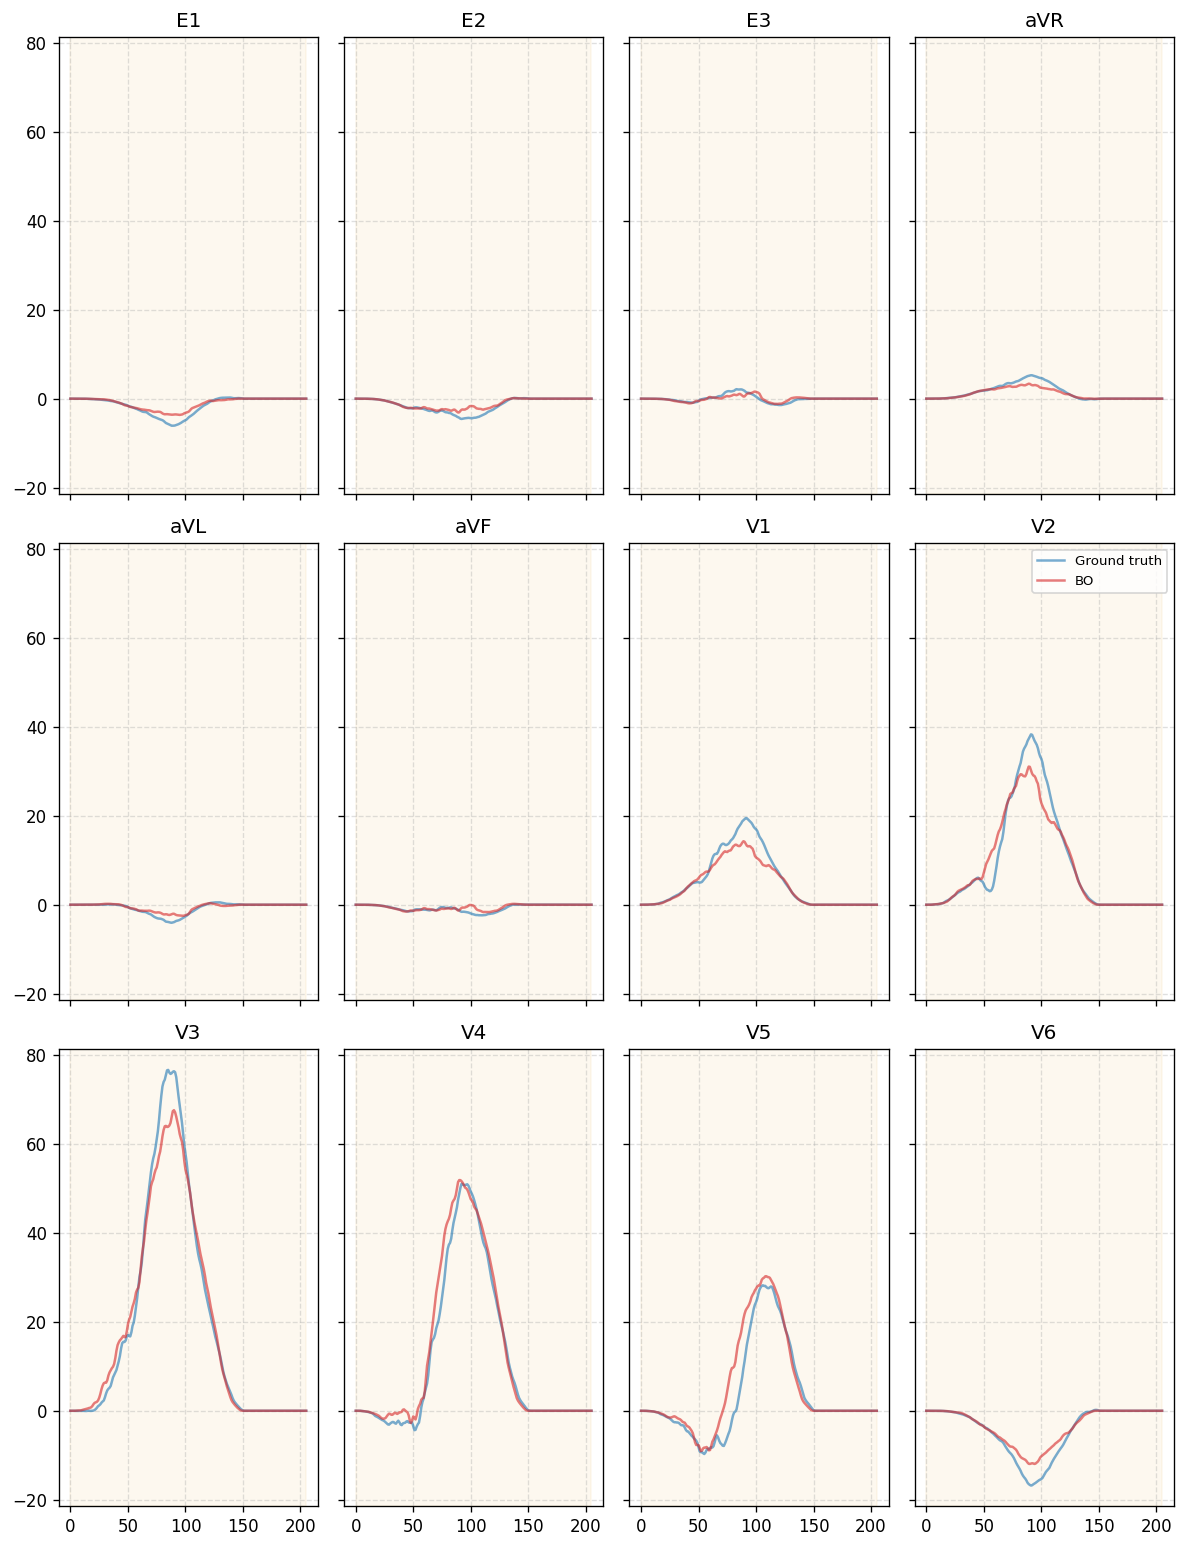

In [35]:
plot_best_ecg = True

if plot_best_ecg:
    # Plot the best ecg found by the BO along with the reference ecg
    bo_method.plot_ecg_match(predicted = ecg_bo, filename_match = file_name)

In [37]:
# Save tree
bo_method.bo_purkinje_tree.myocardium.save_pv(file_name+"_myo.vtu")
LVtree_bo.save(file_name+"_LVtree.vtu")
RVtree_bo.save(file_name+"_RVtree.vtu")

In [ ]:
plot_pairplot_bo = False

if plot_pairplot_bo:
    # Create columns names for pairplot
    df_columns = []
    if "init_length" in var_parameters.keys():
        df_columns += ["In. Length L", "In. Length R"]
        
    if "length" in var_parameters.keys():
        df_columns += ["Length"]
        
    if "w" in var_parameters.keys():
        df_columns += ["w"]
        
    if "fascicles_length" in var_parameters.keys():
        df_columns += ["Fas. Length L1", "Fas. Length L2", "Fas. Length R1", "Fas. Length R2"]
        
    if "fascicles_angles" in var_parameters.keys():
        df_columns += ["Fas. Angle L1", "Fas. Angle L2", "Fas. Angle R1", "Fas. Angle R2"]
        
    if "branch_angle" in var_parameters.keys():
        df_columns += ["Branch Angle"]
        
    if "root_time" in var_parameters.keys():
        df_columns += ["Root time"]
        
    if "cv" in var_parameters.keys():
        df_columns += ["CV"]

    # Create data frame with training + optimization points
    df      = pd.DataFrame(X, columns = df_columns)
    df["y"] = y

    # Discretize the continuous variable into bins
    num_bins       = 5
    bin_labels     = [f'Bin {i}' for i in range(1, num_bins + 1)]
    df['hue_bins'] = pd.cut(df['y'], bins = num_bins, labels = bin_labels)

    # Plot the pairplot with hue as the discretized variable
    sns.pairplot(df, hue='hue_bins')

### Rejection sampling

In [ ]:
def find_std_ybest_ecgs(X, y, qrs_in, qrs_fin, var_parameters, bo_class, ecg_patient):
    print (f"Find MSE_best curve ...")

    # Find L_best and std_best comparing y_best = min(y) with all ecgs
    X_min            = X[np.argmin(y)]
    ecg_min, _, _, _ = bo_class.update_purkinje_tree(np.array([X_min]), 1., var_parameters)
    print (f"X_min = {X_min}")
    print (f"y_min = {np.min(y)}")

    # Compare with ecgs of all times (not with the mean of them, as previously)
    mse_values_best = []
    names           = list(ecg_patient.keys())
    for ecg_ind in np.arange(ecg_patient[names[0]].shape[1]):

        ecg_pat_ind = []
        for items in list(ecg_patient.items()):
            ecg_pat_ind.append(items[1][:,ecg_ind] / 1e3)

        ecg_pat_array_ind = onp.rec.fromarrays(ecg_pat_ind, names=names)
        ecg_pat_array_ind = ecg_pat_array_ind[qrs_in:qrs_fin]

        mse_values_best.append(bo_class.calculate_loss(predicted = ecg_min,
                                                       ecg_pat   = ecg_pat_array_ind))

#     L_best_data   = np.mean(np.array(mse_values_best))
#     std_best_data = np.std(np.array(mse_values_best))
    return mse_values_best

In [ ]:
def train_gp_model(X, y, options, bo_class, X_star_uniform, gp_state = None):
    if gp_state is None:
        print ("Train GP model with valid points...")
        valid = y != bo_class.y_trees_non_valid

        X_valid = X[valid]
        y_valid = y[valid]
        
        print (f"{len(X_valid)} valid points")

        rng_key = random.PRNGKey(0)
        gp_model = GP(options)

        # Fetch normalized training data
        norm_batch, norm_const = normalize(X_valid, y_valid, bo_class.bounds)

        # Train GP model
        t_ini_train = time.time()
        rng_key = random.split(rng_key)[0]
        opt_params = gp_model.train(norm_batch,
                                    rng_key,
                                    num_restarts = 5)
        t_fin_train = time.time()
        print (f"Training time: {t_fin_train - t_ini_train} s")

        kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': bo_class.bounds}
        #               'kappa': gp_model.options['kappa'],
        #               'gmm_vars': gmm_vars,
        #               'rng_key': rng_key}
        
        gp_state = [gp_model, [norm_batch, norm_const], kwargs]

    else:
        print ("Re-using gp_model (it is not trained again with the new points X, y)...")
        gp_model               = gp_state[0]
        norm_batch, norm_const = gp_state[1]
        kwargs                 = gp_state[2]
        
    # Compute predicted mean and std
    t_ini_pred = time.time()

    # batches
    n_col = 100
    assert (len(X_star_uniform)/n_col).is_integer(), "Modify n_col"

    reshaped_X      = [X_star_uniform[i:i+n_col] for i in range(0, len(X_star_uniform), n_col)]
    mean_it, std_it = lax.map(lambda x: gp_model.predict(x, **kwargs),np.array(reshaped_X))
    mean_it         = mean_it.reshape((1,-1))[0]
    std_it          = std_it.reshape((1,-1))[0]

    # # full
    # mean_it, std_it = gp_model.predict(X_star_uniform, **kwargs)

    t_fin_pred = time.time()
    print (f"Predicting time: {t_fin_pred - t_ini_pred} s")
    
    # Obtain ys and sigmas of X_star_uniform (test points with uniform sampling)
    ys     = mean_it * norm_const["sigma_y"] + norm_const["mu_y"]
    sigmas = std_it * norm_const["sigma_y"]
    
    # Obtain min values predicted by gp model
    X_min             = X[np.argmin(y)]
    mean_min, std_min = gp_model.predict(X_min[None,:], **kwargs)

    y_gp_best     = mean_min * norm_const["sigma_y"] + norm_const["mu_y"]
    sigma_gp_best = std_min * norm_const["sigma_y"] # should be low
    
    return ys, sigmas, y_gp_best, sigma_gp_best, gp_state

In [ ]:
def rejection_sampling(ys, sigmas, y_gp_best, sigma_gp_best):
    # Rejection sampling, the likelihood is obtained comparing with best point

    max_likelihood = norm.pdf(x     = 0.,
                              loc   = 0.,
                              scale = np.sqrt(sigma_gp_best**2 + np.min(sigmas)**2))

    key        = random.PRNGKey(0) # onp.random.randint(50)
    comparison = random.uniform(key, shape = (ys.shape[0],)) * max_likelihood

    likelihoods = norm.pdf(x     = 0.,
                           loc   = ys - y_gp_best,
                           scale = np.sqrt(sigmas**2 + sigma_gp_best**2))
     
    accepted_samples = likelihoods > comparison    

    print(f"{accepted_samples.sum()} accepted samples")
    return accepted_samples, comparison, likelihoods

In [ ]:
def check_accepted_samples(N_samples, X_star_uniform, y_gp_best, accepted_samples, comparison, likelihoods,
                           var_parameters, bo_class, tol, observed_samples, confirmed_samples, folder_trees):
                           # sigma_gp_best, std_best_data

    X_accepted           = X_star_uniform[accepted_samples]
    comparison_accepted  = comparison[accepted_samples]
    likelihoods_accepted = likelihoods[accepted_samples]
    
    sorted_indices       = np.argsort(-likelihoods_accepted)

    X_accepted           = X_accepted[sorted_indices]
    comparison_accepted  = comparison_accepted[sorted_indices]
    
    X_true_new           = []
    Y_true_new           = [] # true value of X_accepted
    
    if len(confirmed_samples) == 0:
        confirmed_samples["samples_final"]  = []
        confirmed_samples["ecg_final"]      = []
#         confirmed_samples["endo_final"] = []
        confirmed_samples["Tree_final"]     = []
        confirmed_samples["loss_final"]     = []

    print (f"tolerance: {tol}")        
    
    state                = []
    observed_samples_new = []

    X_ind        = 1
    n_candidates = accepted_samples.sum()
    for x_accepted, comp in zip(X_accepted, comparison_accepted):

        print (f"Checking point {X_ind}/{n_candidates}")

        observed = False
        for obs_elem in observed_samples:
            if np.array_equal(obs_elem[0], x_accepted):
                print ("Point already observed")
                observed = True
                X_ind   += 1
                break
                
        if observed == True:
            continue
        
        elif observed == False:
            try:
                ecg_i, endo_i, LVtree_i, RVtree_i = bo_class.update_purkinje_tree(np.array([x_accepted]), 
                                                                                  1., 
                                                                                  var_parameters)
            except:
                print ("The fascicle goes out of the domain")
                X_true_new.append(x_accepted)
                Y_true_new.append(bo_class.y_trees_non_valid)
                state.append("rejected")
                
                observed_samples_new.append([x_accepted, "non_valid"])
                
                X_ind += 1
                continue

            loss_i, ind_loss_i = bo_class.calculate_loss(predicted         = ecg_i,
                                                         cross_correlation = True,
                                                         return_ind        = True)
            
            observed_samples_new.append([x_accepted,
                                        [ecg_i, endo_i, LVtree_i, RVtree_i, loss_i, ind_loss_i]])
        
        y_true = loss_i
        print (f"Loss: {loss_i}")
        
        X_true_new.append(x_accepted)
        Y_true_new.append(y_true)
        
        # Accept points such that y_true - y_best < tol
        err_value = y_true - y_gp_best
        print (f"y_true - y_gp_best: {err_value}")

        if err_value < tol:
            state.append("accepted")
            confirmed_samples["samples_final"].append(x_accepted)
            confirmed_samples["ecg_final"].append([ecg_i, ind_loss_i])
#             confirmed_samples["endo_final"].append([endo_i])
            confirmed_samples["Tree_final"].append([LVtree_i, RVtree_i])
            confirmed_samples["loss_final"].append(loss_i)
            
            n_conf = len(confirmed_samples["samples_final"])
            print (f"Sample accepted! (n°{n_conf-1}, {n_conf}/{N_samples})")
        
            # If selected, save Trees and propeiko
            tree_ind_test = n_conf - 1
            
            LVtree_i.save(f"./output/patient{patient_number}"+
                                      folder_trees+
                                      f"/LVtree_N{N}_nIter{nIter}"+
                                      "_criterion"+str(options["criterion"])+
                                      f"_{tree_ind_test}.vtu")
            RVtree_i.save(f"./output/patient{patient_number}"+
                                     folder_trees+
                                     f"/RVtree_N{N}_nIter{nIter}"+
                                     "_criterion"+str(options["criterion"])+
                                     f"_{tree_ind_test}.vtu")
            endo_i.save_pv(f"./output/patient{patient_number}"+
                                     folder_trees+
                                     f"/propeiko_N{N}_nIter{nIter}"+
                                     "_criterion"+str(options["criterion"])+
                                     f"_{tree_ind_test}.vtu")
        
        else:        
            state.append("rejected")
            print ("Sample rejected")

        if len(confirmed_samples["samples_final"]) >= N_samples:
            return "ok", confirmed_samples

        # If we don't add any samples after, let's say 50 iterations, we should stop, 
        # retrain the GP and then do this again, using the same random number for comparison
        n_rej_max = 50 
        if len(state) >= n_rej_max and state[-n_rej_max:] == ["rejected"] * n_rej_max:
            end_time = time.time()
            print(f"Elapsed time: {end_time - start_time}")

            n_conf   = len(confirmed_samples["samples_final"])
            print (f"No sample accepted in the last {n_rej_max} iterations ({n_conf} accepted)")
            
            info_final = {"X_true_new"       : X_true_new,
                          "Y_true_new"       : Y_true_new,
                          "Observed_samples" : observed_samples + observed_samples_new,
                          "Confirmed_samples": confirmed_samples}
            
            return "retrain gp", info_final
        
        X_ind += 1
    
    # all samples were observed
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time}")

    n_conf   = len(confirmed_samples["samples_final"])
    print (f"All samples were observed, but only {n_conf} accepted.")

    info_final = {"X_true_new"       : X_true_new,
                  "Y_true_new"       : Y_true_new,
                  "Observed_samples" : observed_samples+observed_samples_new,
                  "Confirmed_samples": confirmed_samples}
    
    return "retrain gp", info_final

In [ ]:
# Loop for finding and accepting "N_samples" candidates
options = {'kernel'     : 'Matern12', # 'Matern52'
           'criterion'  : criterion_bo, # EI: expected improvement; LW-LCB
           'input_prior': p_x,
           'kappa'      : 2.0,
           'nIter'      : nIter}

nn           = 5000000 # test points
N_samples    = 30 # 2 #
tol          = 100.
rejection_n  = 1
gp_rejection = None
obs_samples  = []
conf_samples = {}

# Folder to save trees
folder_trees = f"/Trees_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}"
if os.path.exists(f"./output/patient{patient_number}"+folder_trees):
    shutil.rmtree(f"./output/patient{patient_number}"+folder_trees)

os.makedirs(f"./output/patient{patient_number}"+folder_trees)

while True:
    print ("")
    print (f"Rejection loop {rejection_n}")

    y_best = np.min(y)
    
    # Uniform sampling
    key        = random.PRNGKey(rejection_n - 1) # 0
    X_star_uni = bo_method.lb_params + (bo_method.ub_params - bo_method.lb_params) * random.uniform(key, shape = (nn, bo_method.dim))

    # Train with valid points
    ys, sigmas, y_gp_best, sigma_gp_best, gp_rejection = train_gp_model(X,
                                                                        y,
                                                                        options,
                                                                        bo_class       = bo_method,
                                                                        X_star_uniform = X_star_uni,
                                                                        gp_state       = None) # gp_rejection (to not re-train in each loop)

    accepted_samples, comparison, likelihoods = rejection_sampling(ys,
                                                                   sigmas,
                                                                   y_gp_best,
                                                                   sigma_gp_best)

    state_final, info_final = check_accepted_samples(N_samples         = N_samples,
                                                     X_star_uniform    = X_star_uni,
                                                     y_gp_best         = y_gp_best,
                                                     accepted_samples  = accepted_samples,
                                                     comparison        = comparison,
                                                     likelihoods       = likelihoods,
                                                     var_parameters    = var_parameters,
                                                     bo_class          = bo_method,
                                                     tol               = tol,
                                                     observed_samples  = obs_samples,
                                                     confirmed_samples = conf_samples,
                                                     folder_trees      = folder_trees)
    
    if state_final == "ok":
        samples_final  = info_final["samples_final"]
        ecg_final      = info_final["ecg_final"]
#         endo_final = info_final["endo_final"]
        Tree_final     = info_final["Tree_final"]
        loss_final     = info_final["loss_final"]

        onp.save(f"./output/patient{patient_number}/rejection_X_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", X)
        onp.save(f"./output/patient{patient_number}/rejection_y_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", y)
        
        break
        
    elif state_final == "retrain gp":
        obs_samples  = info_final["Observed_samples"]
        conf_samples = info_final["Confirmed_samples"]        
        
        X_new = info_final["X_true_new"]
        y_new = info_final["Y_true_new"]
        y_new = np.asarray(y_new)
        
        X = np.concatenate([X, np.array(X_new)], axis = 0)
        y = np.concatenate([y, y_new], axis = 0)
        
        assert len(X_new) == len(y_new), "Something is wrong"
        print (f"Retrain the gp model with {len(X_new)} new points")

    if rejection_n == 50:
        onp.save(f"./output/patient{patient_number}/rejection_X_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", X)
        onp.save(f"./output/patient{patient_number}/rejection_y_N_{N}_nIter_{nIter}_criterion_{criterion_bo}_nn_{nn}_tol_{tol}_rejection_n_{rejection_n}", y)
        
        end_time = time.time()
        print("Elapsed time: " + str(end_time - start_time))
        raise Exception(f"It was not possible to find and check {N_samples} samples")
    
    rejection_n += 1

In [ ]:
save_final = True

if save_final:
    pickle.dump(ecg_final, open(f"./output/patient{patient_number}/ecg_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}","wb"))
    onp.save(f"./output/patient{patient_number}/X_final_N{N}_nIter{nIter}_criterion{criterion_bo}_variableparams_{list_variable_params}.npy",samples_final)

In [ ]:
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} s")